# 4. Data Modeling

---
**Intro to Data Science - Final Project**
- **Team members**:
    - Nguyễn Duy Đăng Khoa - 21127078
    - Nguyễn Ngọc Vũ - 21127483
    - Phạm Nguyễn Quốc Thanh - 21127428
    - Nguyễn Vinh Quang - 20127606
- **Intructor**:
    - Mr. Nguyễn Bảo Long
---

- **Problem definition:**
    - Predicting movie ratings (audience score).
    - This problem can be useful in building recommender systems, trend forecasting,...
- **Models used:**
    1. [Linear Regression](#1-linear-regression)
    2. [Gradient Boosting Regressor](#2-gradient-boosting-regressor)
    3. [Neural Network](#3-neural-network)
- **Metric used for evaluation:** **Mean Squared Error (MSE)**
    - We use **MSE** because when predicting ratings, it is much more acceptable to predict a rating within 1 value of the actual rating (4.5 vs 5).
    - It should be very bad if the predictions are too far from the actual values (2 vs 5)
    - So, we need a metric that **emphasizes big errors, while minimizing errors within the 0-1 range**. (if error is 0.5 then MSE is 0.25)
    - MSE is very suitable for this problem.
- [**Comparison and Conclusion**](#4-comparison-and-conclusion)

## 1. Linear Regression

### Setup

In [146]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
import movecolumn as mc
from sklearn.metrics import mean_squared_error as mse

### Prepare data

In [147]:
df = pd.read_csv('../../data/processed/data.csv')
df.sample(5)

,name,genre,tomatometer_score,tomatometer_count,audience_score,audience_count,classification,runtime,release_year,original_language
847,Black Crab,Action,0.52,31.0,0.54,250.0,Not Rated,110.0,2022,Swedish
1032,Bad Santa 2,Holiday,0.23,135.0,0.34,10000.0,R,92.0,2016,English
804,True Grit,Western,0.88,56.0,0.84,25000.0,G,128.0,1969,English
155,To All the Boys I've Loved Before,Romance,0.96,70.0,0.85,5000.0,TV14,99.0,2018,English
244,Deadpool,Action,0.85,348.0,0.90,100000.0,R,108.0,2016,English


Now, we will drop the 'name' column, as it is not useful for the model.

In [148]:
df = df.drop(columns='name')

In the 'original_language' column, we just need the main language.

In [149]:
df['original_language'] = df['original_language'].str.split(' ').str[0]

Now, we perform one-hot encoding on the categorical columns.

In [150]:
cols_to_onehot = ['original_language', 'genre', 'classification']
df = pd.get_dummies(df, columns=cols_to_onehot)

We will move the target column to the end of the dataframe and then fill the missing values with mean.

In [151]:
df = mc.MoveToLast(df, 'audience_score')
df.fillna(df.mean(), inplace=True)

### Data splitting

In [152]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='audience_score'), df['audience_score'], test_size=0.1)
linear_y_train = y_train #save for comparison

### Data modeling
**Model 1**: Linear Regression
- Reason: We want to predict the audience score, which is a continuous variable. Therefore, we will use linear regression.

In [153]:
kfold = KFold(n_splits=10, shuffle=True)
LinearRegressionModel = LinearRegression()
## Mô hinh sử dụng tất cả các thuộc tính
first_model = X_train
first_model_test = X_test
first_model_name = 'All Features'

## Mô hình không sử dụng "tomatometer_count" và "tomatometer_score"
second_model = X_train.drop(columns=['tomatometer_count', 'tomatometer_score'])
second_model_test = X_test.drop(columns=['tomatometer_count', 'tomatometer_score'])
second_model_name = 'Without tomatometer_count and tomatometer_score'

# Mô hình không sử dụng "tomatometer_score"
third_model = X_train.drop(columns=['tomatometer_score'])
third_model_test = X_test.drop(columns=['tomatometer_score'])
third_model_name = 'Without tomatometer_score'


models_train = [first_model, second_model, third_model]
models_test = [first_model_test, second_model_test, third_model_test]
models_name = [first_model_name, second_model_name, third_model_name]
average_mse = np.zeros(len(models_train))
average_mse = [np.abs(cross_val_score(LinearRegression(fit_intercept=False), model, y_train, cv=kfold, scoring='neg_mean_squared_error').mean()) for model in models_train]
data = []
for i in range(len(models_train)):
    data.append([models_name[i], average_mse[i]])
res_df = pd.DataFrame(data, columns=['Mô hình', 'MSE'])
res_df.sort_values(['MSE'], inplace=True)

In [154]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
best_model_index = np.argmin(average_mse)
my_best_model = LinearRegression(fit_intercept=False).fit(models_train[best_model_index], y_train)

In [155]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
y_hat_best = my_best_model.predict(models_test[best_model_index])
linear_mse = mse(y_test, y_hat_best)
print("MSE trên tập kiểm tra: ", linear_mse)

MSE trên tập kiểm tra:  0.02156328525264906


## 2. Gradient Boosting Regressor
- We'll use the model ```GradientBoostingRegressor``` from `sklearn`.
- **Advantages of this model**
    - **Flexible to outliers**: As the model performs gradient boosting, through each iteration outliers will have less impact.
    - **Works well for small sized data**: Unlike other deep learning models that utilize gradients, Gradient Boosting Regressor can be effective even with a small dataset.

### Setup

In [156]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing

In [157]:
#Read data
df = pd.read_csv('../../data/processed/data.csv')
df.head()

,name,genre,tomatometer_score,tomatometer_count,audience_score,audience_count,classification,runtime,release_year,original_language
0,A Castle for Christmas,Holiday,0.74,23.0,0.40,100.0,Not Rated,98.0,2021,English
1,Pinocchio,Kids & family,1.00,61.0,0.73,250000.0,G,87.0,1940,English
2,The Informer,Mystery & thriller,0.64,58.0,0.60,250.0,R,113.0,2019,English
3,They Cloned Tyrone,Sci-fi,0.95,129.0,1.00,25.0,R,122.0,2023,English
4,1917,War,0.89,472.0,0.88,25000.0,R,119.0,2019,English


In [158]:
#Choose numeric features
df = df.select_dtypes('number')
#Fill na values with mean
df = df.fillna(df.mean())

### Train, Validation, Test set splitting
- We'll perform splitting on the following ratio (70/20/10)

In [159]:
train, validation, test = np.split(df.sample(frac=1, random_state=30), [int(0.7*len(df)), int(0.9*len(df))]) #70/20/10

### Hyperparameter tuning
- We'll perform hyperparameter tuning on two hyperparameters: `learning_rate` and `n_estimator`.
- We'll record the `mean_squared_error` of every combination of these parameters on the validation set.
- Finally, we'll plot the corresponding heatmap.

In [160]:
from itertools import product

learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
n_estimators = [50, 75, 100, 125, 150]

results = np.zeros((5,5))
for rate, n in product(learning_rates, n_estimators):
    #Initalize model and perform fitting
    model = GradientBoostingRegressor(loss='squared_error', learning_rate=rate, n_estimators=n)
    model.fit(train.drop('audience_score', axis=1), train['audience_score'])
    #Testing on validation set and record error
    val_predictions = model.predict(validation.drop('audience_score', axis=1))
    error = mean_squared_error(validation['audience_score'], val_predictions)
    results[learning_rates.index(rate)][n_estimators.index(n)] = error

Plotting the heatmap

Text(0.5, 1.0, 'Error matrix of model on different learning_rate and n_estimators')

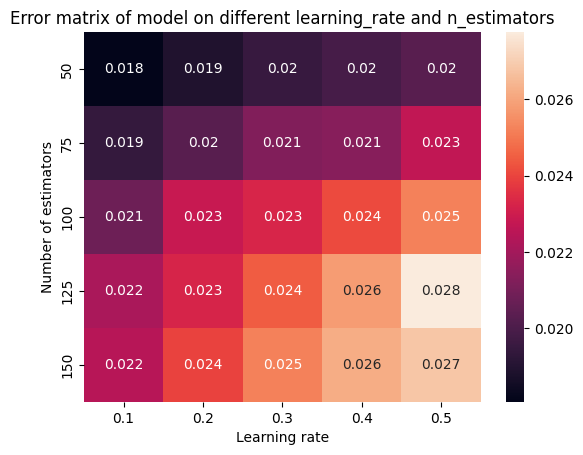

In [161]:
sns.heatmap(results, xticklabels=learning_rates, yticklabels=n_estimators, annot=True)
plt.xlabel('Learning rate')
plt.ylabel('Number of estimators')
plt.title('Error matrix of model on different learning_rate and n_estimators')

So, the best hyperparameters are `learning_rate = 0.1` and `n_estimators = 50`.

### Training and Testing/Evaluation
- We perform fitting on training + validation set.
- Use squared error as the loss function.

Training

In [162]:
best_lr = 0.1
best_n = 50

train_validation = pd.concat([train, validation])
gradient_boost = GradientBoostingRegressor(loss='squared_error', learning_rate=best_lr, n_estimators=best_n)
gradient_boost.fit(train_validation.drop('audience_score', axis=1), train_validation['audience_score'])

GradientBoostingRegressor(n_estimators=50)

Visualizing the running process

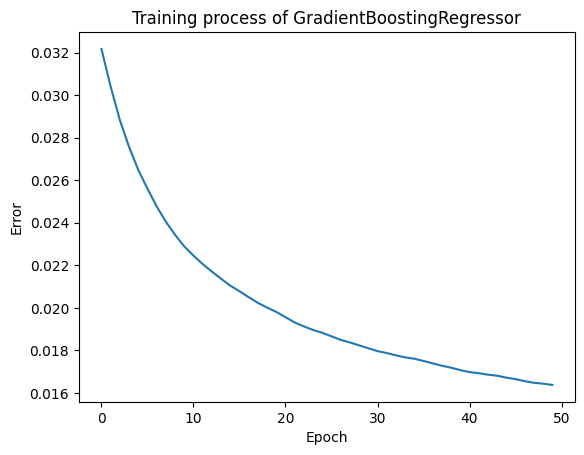

In [163]:
gradient_boost_scores = gradient_boost.train_score_
plt.plot(gradient_boost_scores)
plt.title('Training process of GradientBoostingRegressor')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

Testing

In [164]:
predictions = gradient_boost.predict(test.drop('audience_score', axis=1))
gb_mse = mean_squared_error(test['audience_score'], predictions)
print("MSE:", gb_error)

MSE: 0.02011367200283793


## 3. Neural Network
- We'll use the model ```NeuralNetwork``` from `tensorflow`.
- **Advantages of this model**
    - **Feature Interactions**: The selected features include a mix of numerical and categorical variables (tomatometer_score, tomatometer_count, audience_count, runtime, genre, classification, original_language). Neural networks can effectively handle both types of features and capture interactions between them, which is crucial when dealing with diverse types of data.
    - **Representation Learning**: Neural networks have the ability to automatically learn hierarchical representations of the input data. This is advantageous when dealing with categorical variables like genre, classification, and original_language because the model can learn meaningful representations rather than relying on handcrafted feature engineering.

### Setup

In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns

### Preprocessing

In [166]:
# Load your data
data = pd.read_csv('../../data/processed/data.csv')
data.head()

,name,genre,tomatometer_score,tomatometer_count,audience_score,audience_count,classification,runtime,release_year,original_language
0,A Castle for Christmas,Holiday,0.74,23.0,0.40,100.0,Not Rated,98.0,2021,English
1,Pinocchio,Kids & family,1.00,61.0,0.73,250000.0,G,87.0,1940,English
2,The Informer,Mystery & thriller,0.64,58.0,0.60,250.0,R,113.0,2019,English
3,They Cloned Tyrone,Sci-fi,0.95,129.0,1.00,25.0,R,122.0,2023,English
4,1917,War,0.89,472.0,0.88,25000.0,R,119.0,2019,English


In [167]:
# Define numerical and categorical features
numerical_features = ['tomatometer_score', 'tomatometer_count', 'audience_count', 'runtime']
categorical_features = ['genre', 'classification', 'original_language']

# Select specific features
selected_features = ['tomatometer_score', 'tomatometer_count', 'audience_count', 'runtime', 'genre', 'classification', 'original_language']
#Handle missing values
data.dropna(subset=numerical_features+['audience_score'], inplace=True)

### Train, Validation, Test set splitting
- We'll perform splitting on the following ratio (70/20/10)

In [168]:
# Select features and target variable
X = data[selected_features]
y = data['audience_score']

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

### Transformer

In [169]:
# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [170]:
# Fit the ColumnTransformer on the training data
preprocessor.fit(X_train)

C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['tomatometer_score', 'tomatometer_count',
                                  'audience_count', 'runtime']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['genre', 'classification',
                                  'original_language'])])

### Hyperparameter tuning
- We'll perform hyperparameter tuning on two hyperparameters: `learning_rate` and `batch_size`.
- We'll record the `mean_squared_error` of every combination of these parameters on the validation set.
- Finally, we'll plot the corresponding heatmap.

### Model Layers
- Input Layer:
    - Type: Dense
    - Number of Neurons: 64
    - Activation Function: ReLU
    - Input Dimension: preprocessor.transform(X_train).shape[1]
    - This layer is the first hidden layer with ReLU activation.
- Hidden Layer:
    - Type: Dense
    - Number of Neurons: 32
    - Activation Function: ReLU
    - This is the second hidden layer with ReLU activation.
- Output Layer:
    - Type: Dense
    - Number of Neurons: 1
    - Activation Function: Linear
    - This is the output layer with a linear activation function, suitable for regression tasks.

In [171]:
# Combine preprocessing with model training in a pipeline
modelNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Sequential([
        Dense(64, activation='relu', input_dim=preprocessor.transform(X_train).shape[1]),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ]))
])

### Optimizer
- Using Adam optimizer for Neural Network Model

In [172]:
# Hyperparameters
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005]
batch_size = [50, 75, 100, 125, 150]

# Compile the Keras model with specified learning rate
results = np.zeros((5, 5))
for rate, bat in product(learning_rates, batch_size):
    optimizer = Adam(learning_rate=rate)
    modelNN.named_steps['regressor'].compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model with a reduced number of epochs
    modelNN.named_steps['regressor'].fit(
        preprocessor.transform(X_train), y_train,
        epochs=50, batch_size=bat,verbose=0)

    # Testing on the validation set and record error
    y_val_pred = modelNN.predict(X_val)
    error = mean_squared_error(y_val, y_val_pred)
    results[learning_rates.index(rate)][batch_size.index(bat)] = error

4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 3ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 3ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 3ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 4ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


4/4 [==============================] - 0s 2ms/step


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Plotting the heatmap

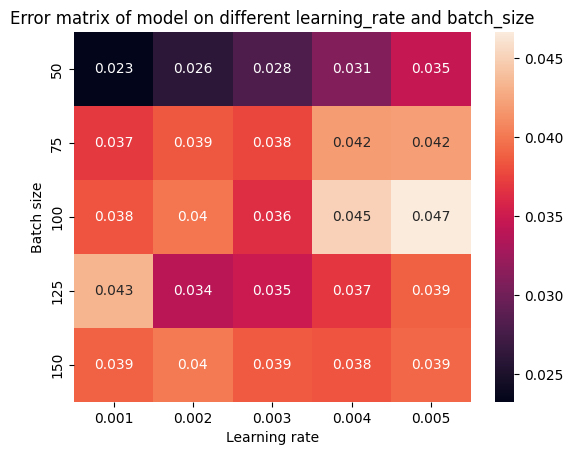

In [173]:
sns.heatmap(results, xticklabels=learning_rates, yticklabels=batch_size, annot=True)
plt.xlabel('Learning rate')
plt.ylabel('Batch size')
plt.title('Error matrix of model on different learning_rate and batch_size')
plt.show()

So, the best hyperparameters are `learning_rate = 0.001` and `batch_size = 50`.

### Training and Testing/Evaluation
- We perform fitting on training + validation set.
- Use squared error as the loss function.

Training

In [174]:
best_lr=0.001
best_bz=50

optimizer = Adam(learning_rate=best_lr)
modelNN.named_steps['regressor'].compile(optimizer=optimizer, loss='mean_squared_error')

history=modelNN.named_steps['regressor'].fit(
        preprocessor.transform(pd.concat([X_train,X_val])), pd.concat([y_train,y_val]),
        epochs=50, batch_size=best_bz,verbose=0)

C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Visualizing the running process

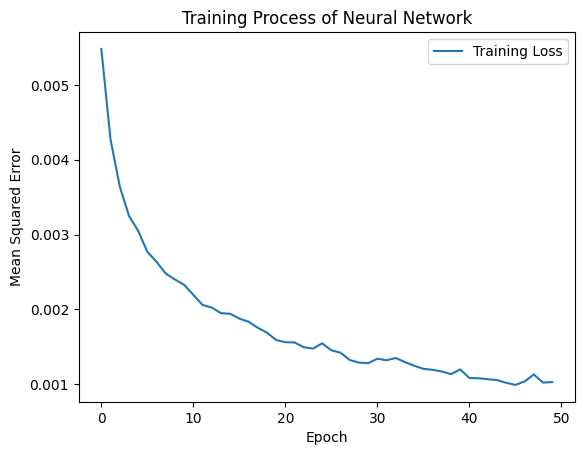

In [175]:
# Visualize training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Process of Neural Network')
plt.legend()
plt.show()

Testing

In [176]:
y_test_pred = modelNN.predict(X_test)
nn_mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", mse)

8/8 [==============================] - 0s 2ms/step
MSE: <function mean_squared_error at 0x000002938E497740>


C:\Users\khoan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## 4. Comparison and Conclusion

Running process

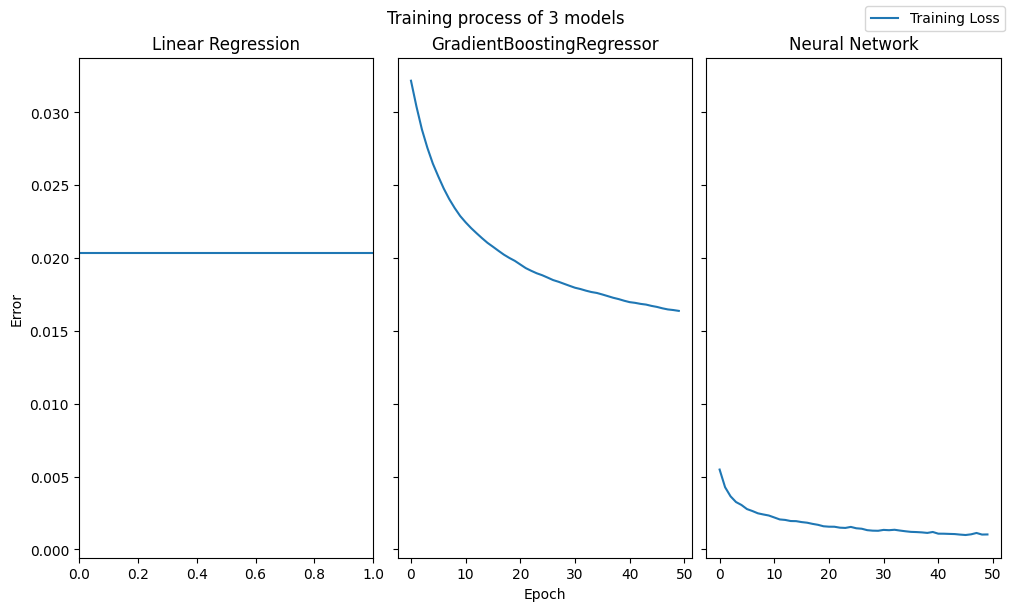

In [177]:
fig = plt.figure(figsize=(10,6),layout='constrained')
axs = fig.subplots(1,3, sharey=True)
#Linear regression
lr_mse = mean_squared_error(my_best_model.predict(models_train[best_model_index]), linear_y_train)
axs[0].axhline(lr_mse)
axs[0].set_title('Linear Regression')
axs[0].set_ylabel('Error')
#GradientBoostingRegressor
axs[1].plot(gradient_boost_scores)
axs[1].set_title('GradientBoostingRegressor')
axs[1].set_xlabel('Epoch')
#Neural Network
axs[2].plot(history.history['loss'], label='Training Loss')
axs[2].set_title('Neural Network')

fig.suptitle('Training process of 3 models')
fig.legend();

- We see that within 3 models, **Neural Network** reaches the lowest training error.
- Moreover, **Neural Network** also seems to learn faster than **Gradient Boosting Regressor** (the curve of the training line happens at an earlier epoch).
- **Linear Regression** produces the highest training error.

Evaluation on testset

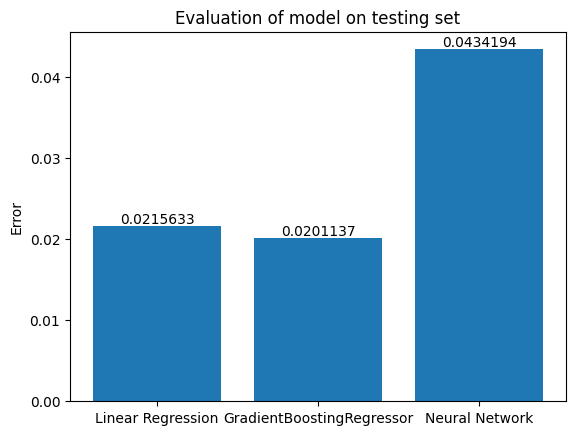

In [178]:
test_errors = [linear_mse, gb_mse, nn_mse]
models = ['Linear Regression', 'GradientBoostingRegressor', 'Neural Network']
ax = plt.bar(models, test_errors)
plt.ylabel('Error')
plt.title('Evaluation of model on testing set')
plt.bar_label(ax);

- We see that the **MSE** on test set of Neural Network is highest. While MSE of the other two models seem to be fairly equal.

### **Conclusion**
- Training:
    - **Linear Regression** provides the fastest training time.
    - **Neural Network** takes a longer time through each epoch, but seems to learn faster than **GradientBoostingRegressor**.
- Testing Evaluation:
    - Despite a low training error, **Neural Network** shows the highest testing error. This suggests that NN model has been **overfitted** to the training data.
    - **Linear Regression** and **GradientBoostingRegressor** has a low testing error.
- Summary:
    - For a small dataset, **Neural Network** is very inefficient and becomes very likely to overfit/underfit, we can apply some 'early-stopping' methods to minimize this.
    - **Linear Regression** works well, but might lose accuracy when the dataset becomes larger and more complex (ie. dimensions/samples).
    - **GradientBoostingRegressor** is also sufficient, but it takes more epochs in order to reach the best possible state, which might be time-consuming as the dataset grows.